References: 

> https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/

In [1]:
%cd ../..
%run cryptolytic/notebooks/init.ipynb
import cryptolytic.start as start
start.init()
# stop a warning message from appearing
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
ohclv = ['open', 'high', 'close', 'low', 'volume']

/home/me/Documents/Git/Lambda-School-Labs/cryptolytic-ds
Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
from matplotlib.pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = 20,7

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [3]:
import cryptolytic.data.sql as sql
help(sql.get_some_candles)

Help on function get_some_candles in module cryptolytic.data.sql:

get_some_candles(info, n=10000, verbose=False)
    Return n candles
    info: can contain start (unix-timestamp or str), end, exchange_id, 
        period (in seconds), trading_pair
        Example: info={'start':1546300800, 'end':1546309800, 'exchange_id':'bitfinex',
                       'trading_pair':'eth_btc', 'period':300}



In [4]:
import pandas as pd
df = sql.get_some_candles(
    info={'start':1574368000, 'end':1579046400, 'exchange_id':'hitbtc',
          'trading_pair':'btc_usd', 'period':300}, n=5e4)
df = df.set_index('datetime')
df2 = df.copy()  # mutable copy
train_test_pivot = int(len(df)*0.8)
df['diff'] = df['high'] - df['low']

In [5]:
# Import statsmodel
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller

In [6]:
df.index.max()

Timestamp('2020-01-15 00:00:00')

In [7]:
df.shape, df.head()

((15595, 8),
                         open    close     high      low   timestamp  \
 datetime                                                              
 2019-11-21 20:30:00  7625.38  7626.31  7632.30  7623.67  1574368200   
 2019-11-21 20:35:00  7625.64  7600.47  7625.64  7594.11  1574368500   
 2019-11-21 20:40:00  7600.00  7598.88  7605.62  7583.80  1574368800   
 2019-11-21 20:45:00  7599.79  7590.21  7600.64  7576.03  1574369100   
 2019-11-21 20:50:00  7583.23  7584.00  7591.68  7579.35  1574369400   
 
                         volume  period   diff  
 datetime                                       
 2019-11-21 20:30:00  131.42956     300   8.63  
 2019-11-21 20:35:00   84.75415     300  31.53  
 2019-11-21 20:40:00  208.57723     300  21.82  
 2019-11-21 20:45:00   92.76753     300  24.61  
 2019-11-21 20:50:00  347.91620     300  12.33  )

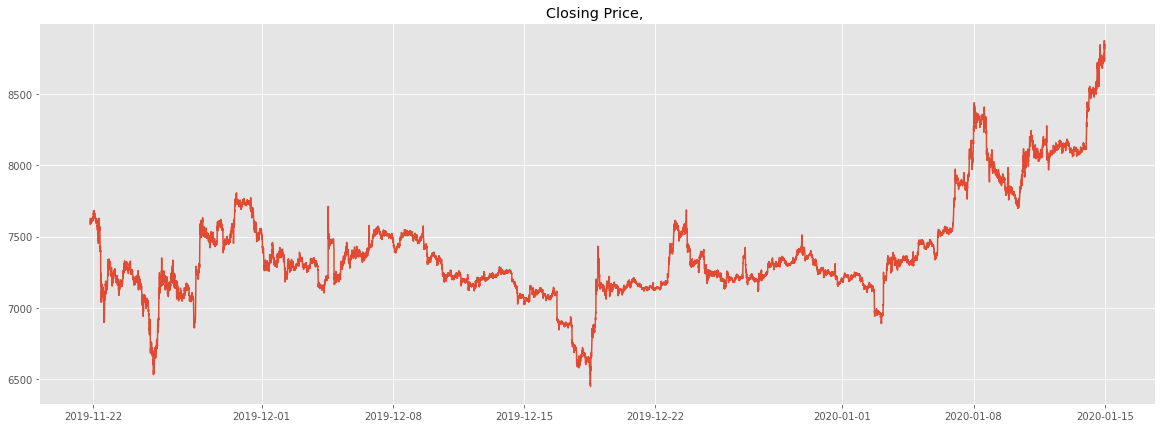

In [8]:
plt.title('Closing Price, ')
plt.plot(df['close'])

In [9]:
import cryptolytic.viz.plot as plot
plot.candlestick(df)

In [10]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, shuffle=False)

# Baseline Prediction using Moving Average

In [11]:
# the predicted price for each day will be the average of a set of previously 
# observed values
preds = []
for i in range(0, test.shape[0]):
    a = train['close'][len(train)-len(test)+i:].sum() + sum(preds)
    b = a / len(test)
    preds.append(b)

print("preds", preds[0:5])

# Check the results 
rms = np.sqrt(np.mean(
    np.power( (np.array(test['close'])-preds), 2) ))

print("Root Mean Squared Error", rms)

preds [7245.68630330234, 7245.680258513402, 7245.673509638286, 7245.665614001749, 7245.6606654971]
Root Mean Squared Error 785.3508040484846


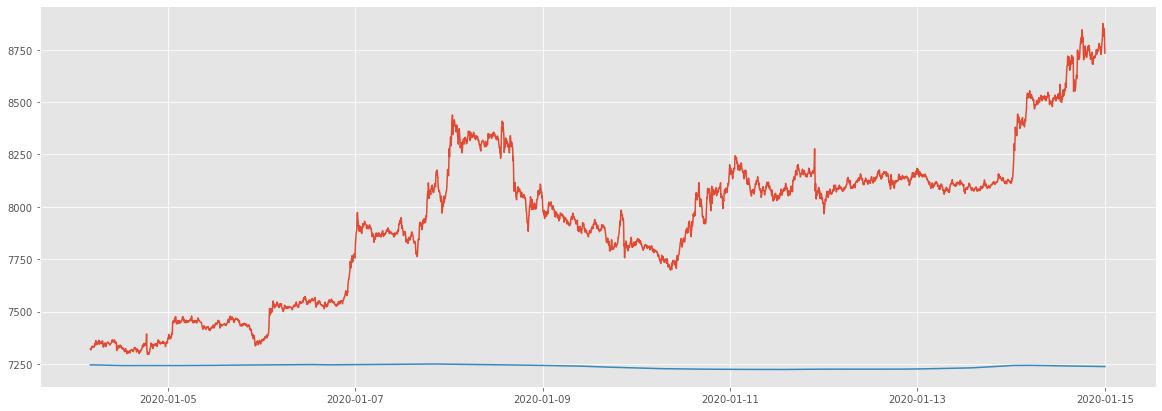

In [12]:
plt.plot(test.index, test['close'])
plt.plot(test.iloc[:len(preds)].index, preds)

# Normalize data

In [13]:
from sklearn import neighbors
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [14]:
df2 = pd.DataFrame(scaler.fit_transform(df[ohclv]), columns=df[ohclv].columns)
df2.index = df.index

In [15]:
df2

open      high     close       low    volume
datetime                                                             
2019-11-21 20:30:00  0.485320  0.482954  0.485549  0.496392  0.062891
2019-11-21 20:35:00  0.485427  0.480195  0.474903  0.484048  0.040556
2019-11-21 20:40:00  0.474826  0.471901  0.474248  0.479742  0.099807
2019-11-21 20:45:00  0.474739  0.469838  0.470676  0.476497  0.044391
2019-11-21 20:50:00  0.467892  0.466127  0.468117  0.477884  0.166483
...                       ...       ...       ...       ...       ...
2020-01-14 23:40:00  0.986434  0.990456  0.975465  0.987986  0.130604
2020-01-14 23:45:00  0.977218  0.985679  0.983182  0.993928  0.231840
2020-01-14 23:50:00  0.985103  0.994727  0.990619  1.000000  0.028860
2020-01-14 23:55:00  0.992429  0.988161  0.972425  0.990984  0.101410
2020-01-15 00:00:00  0.973332  0.971516  0.941739  0.948798  0.538851

[15595 rows x 5 columns]

# KMeans Model With Hyperparameter Tuning

In [16]:
params = {'n_neighbors' : range(2, 10)}
knn = neighbors.KNeighborsRegressor()
model = RandomizedSearchCV(knn, params, cv=5)
x_features = df2.drop('close', axis=1).columns
y_feature = 'close'
train = df2[:train_test_pivot]
test = df2[train_test_pivot+1:]

In [17]:
import cryptolytic.util.core as util
util.bdir(model)

['classes_',
 'cv',
 'decision_function',
 'error_score',
 'estimator',
 'fit',
 'get_params',
 'iid',
 'inverse_transform',
 'n_iter',
 'n_jobs',
 'param_distributions',
 'pre_dispatch',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'random_state',
 'refit',
 'return_train_score',
 'score',
 'scoring',
 'set_params',
 'transform',
 'verbose']

In [18]:
df.iloc[:train_test_pivot].tail(1)

open    close     high      low   timestamp  \
datetime                                                              
2020-01-04 04:05:00  7320.07  7320.78  7324.72  7319.08  1578110700   

                        volume  period  diff  
datetime                                      
2020-01-04 04:05:00  228.81578     300  5.64

In [19]:
preds[0:5]

[7245.68630330234,
 7245.680258513402,
 7245.673509638286,
 7245.665614001749,
 7245.6606654971]

In [20]:
model.fit(train[x_features], train[y_feature])
preds = model.predict(test[x_features])

/home/me/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning:

The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.



In [21]:
rms=np.sqrt(np.mean(np.power((np.array(test[y_feature])-np.array(preds)),2)))
rms

0.14343089767346479

/home/me/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/me/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



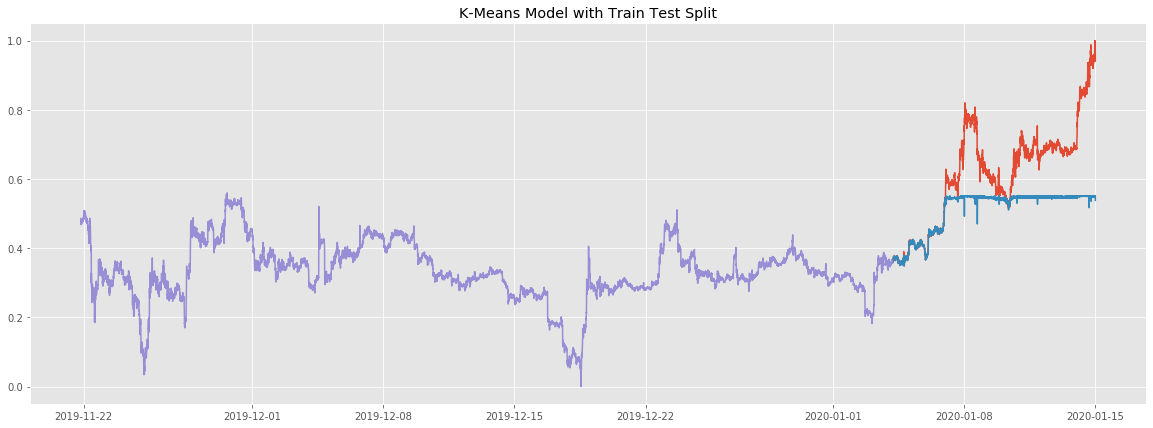

In [22]:
test['preds']  = 0
test['preds'] = preds
plt.title('K-Means Model with Train Test Split')
plt.plot(test[[y_feature, 'preds']])
plt.plot(train['close'])

In [23]:
test.min()

open      0.349067
high      0.344996
close     0.349103
low       0.349851
volume    0.000015
preds     0.348289
dtype: float64

In [24]:
test

open      high     close       low    volume  \
datetime                                                                
2020-01-04 04:15:00  0.361136  0.356135  0.358946  0.369040  0.116510   
2020-01-04 04:20:00  0.357708  0.352407  0.358180  0.366371  0.001401   
2020-01-04 04:25:00  0.357489  0.355418  0.361175  0.367996  0.001324   
2020-01-04 04:30:00  0.361719  0.359453  0.364549  0.371570  0.001098   
2020-01-04 04:35:00  0.363588  0.359200  0.364261  0.372773  0.002337   
...                       ...       ...       ...       ...       ...   
2020-01-14 23:40:00  0.986434  0.990456  0.975465  0.987986  0.130604   
2020-01-14 23:45:00  0.977218  0.985679  0.983182  0.993928  0.231840   
2020-01-14 23:50:00  0.985103  0.994727  0.990619  1.000000  0.028860   
2020-01-14 23:55:00  0.992429  0.988161  0.972425  0.990984  0.101410   
2020-01-15 00:00:00  0.973332  0.971516  0.941739  0.948798  0.538851   

                        preds  
datetime                       
2020-01-04 04:15:00  0.361986  
2020-01-04 04:20:00  0.356777  
2020-01-04 04:25:00  0.359248  
2020-01-04 04:30:00  0.364347  
2020-01-04 04:35:00  0.362209  
...                       ...  
2020-01-14 23:40:00  0.551312  
2020-01-14 23:45:00  0.551312  
2020-01-14 23:50:00  0.551444  
2020-01-14 23:55:00  0.551312  
2020-01-15 00:00:00  0.537966  

[3118 rows x 6 columns]

# LSTM

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

scaler = MinMaxScaler(feature_range=(0, 1))
x = train[x_features]
x = scaler.fit_transform(x)
Xtrain = np.reshape(x, (x.shape[0], x.shape[1], 1))
Ytrain = train[y_feature].values
xt = test[x_features]
xt = scaler.transform(xt)
Xtest = np.reshape(xt, (xt.shape[0], xt.shape[1], 1))
Ytest = test[y_feature].values

def create_model():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(Xtrain.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    return model

def compile_model(model):
    return model.compile(loss='mean_squared_error', optimizer='adam')

def fit_model(model):
    model.fit(Xtrain, Ytrain, epochs=100, batch_size=1, verbose=2)
    
def model_results():
    pass

def evaluate_model(model):
    print(Xtrain[-5:])
    inputs = rolling_window(Xtrain, 100)[-1]
    print(inputs[-2:])
    inputs[:,:,0] = scaler.transform(inputs[:,:,0])
    closing_price = model.predict(inputs)
    return closing_price
    
def run_model():
    model = create_model()
    compile_model(model)
    fit_model(model)

In [26]:
len(df.index)

15595

In [27]:
df.head()

open    close     high      low   timestamp  \
datetime                                                              
2019-11-21 20:30:00  7625.38  7626.31  7632.30  7623.67  1574368200   
2019-11-21 20:35:00  7625.64  7600.47  7625.64  7594.11  1574368500   
2019-11-21 20:40:00  7600.00  7598.88  7605.62  7583.80  1574368800   
2019-11-21 20:45:00  7599.79  7590.21  7600.64  7576.03  1574369100   
2019-11-21 20:50:00  7583.23  7584.00  7591.68  7579.35  1574369400   

                        volume  period   diff  
datetime                                       
2019-11-21 20:30:00  131.42956     300   8.63  
2019-11-21 20:35:00   84.75415     300  31.53  
2019-11-21 20:40:00  208.57723     300  21.82  
2019-11-21 20:45:00   92.76753     300  24.61  
2019-11-21 20:50:00  347.91620     300  12.33

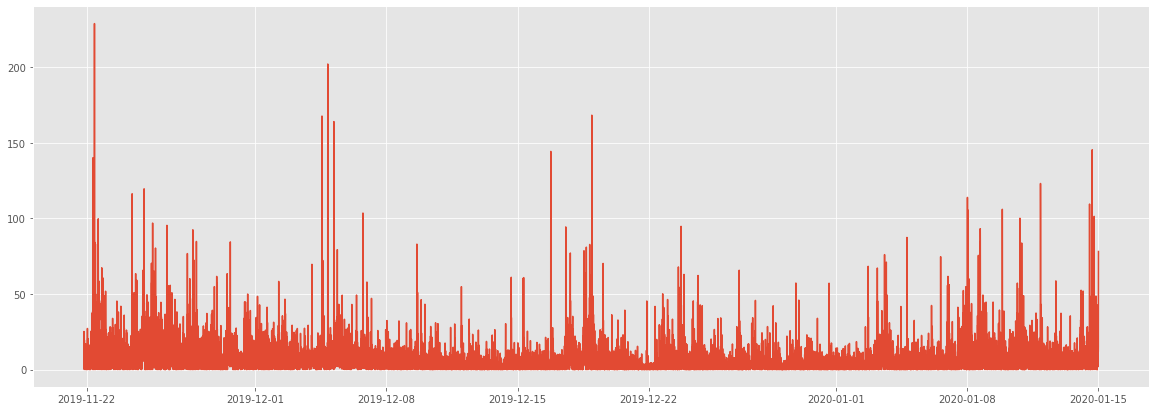

In [28]:
plt.plot(df.index, df['high'] - df['close'])

In [29]:
# Import statsmodel
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller

In [30]:
df.head()

open    close     high      low   timestamp  \
datetime                                                              
2019-11-21 20:30:00  7625.38  7626.31  7632.30  7623.67  1574368200   
2019-11-21 20:35:00  7625.64  7600.47  7625.64  7594.11  1574368500   
2019-11-21 20:40:00  7600.00  7598.88  7605.62  7583.80  1574368800   
2019-11-21 20:45:00  7599.79  7590.21  7600.64  7576.03  1574369100   
2019-11-21 20:50:00  7583.23  7584.00  7591.68  7579.35  1574369400   

                        volume  period   diff  
datetime                                       
2019-11-21 20:30:00  131.42956     300   8.63  
2019-11-21 20:35:00   84.75415     300  31.53  
2019-11-21 20:40:00  208.57723     300  21.82  
2019-11-21 20:45:00   92.76753     300  24.61  
2019-11-21 20:50:00  347.91620     300  12.33

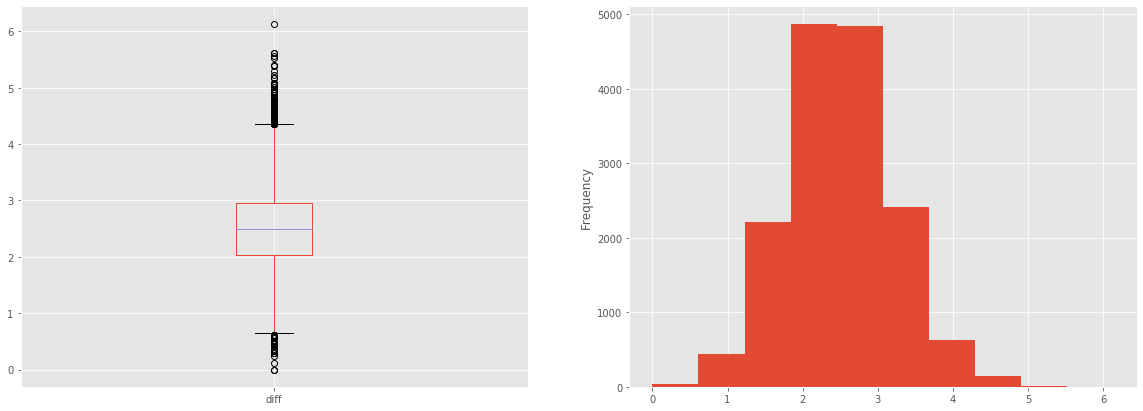

In [31]:
plt.subplot(1, 2, 1)
df['diff'].apply(lambda x: np.log(x + 1)).plot(kind='box')
plt.subplot(1, 2, 2)
df['diff'].apply(lambda x: np.log(x + 1)).plot(kind='hist')

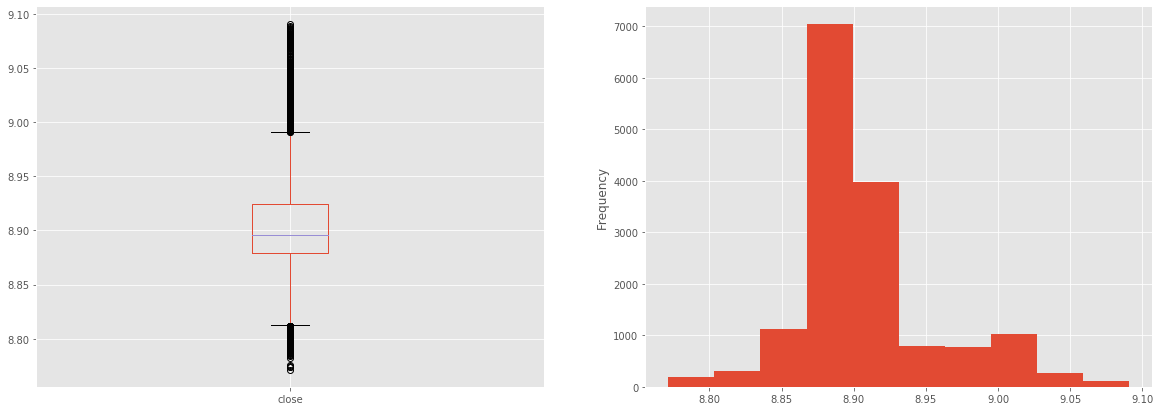

In [32]:
plt.subplot(1, 2, 1)
df['close'].apply(np.log).plot(kind='box')
plt.subplot(1, 2, 2)
df['close'].apply(np.log).plot(kind='hist')

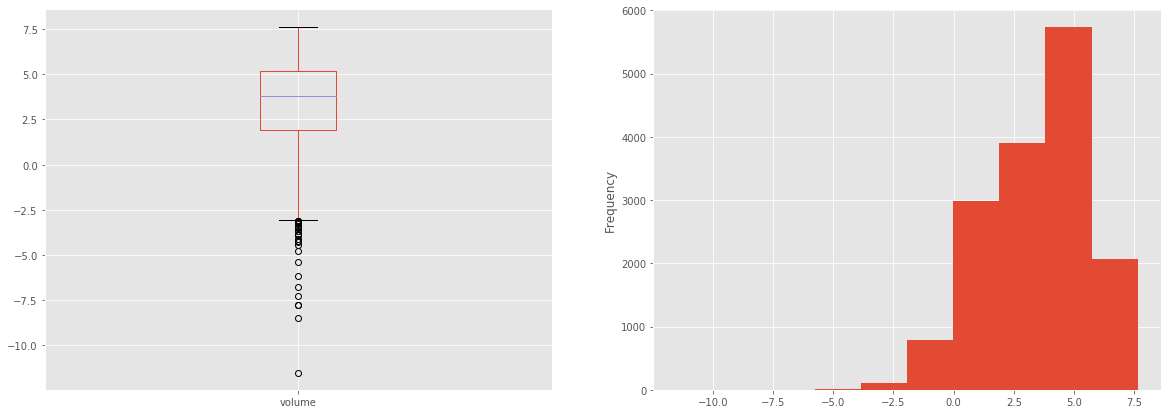

In [33]:
plt.subplot(1, 2, 1)
df['volume'].apply(np.log).plot(kind='box')
plt.subplot(1, 2, 2)
df['volume'].apply(np.log).plot(kind='hist')

In [34]:
df['timedelta'] = df.index - df.index.min()
df2 = df.copy().reset_index()
df2['day_delta'] = df2['timedelta' ]/np.timedelta64(1, 'D')
df2 = df2.set_index('day_delta')
df.head()

open    close     high      low   timestamp  \
datetime                                                              
2019-11-21 20:30:00  7625.38  7626.31  7632.30  7623.67  1574368200   
2019-11-21 20:35:00  7625.64  7600.47  7625.64  7594.11  1574368500   
2019-11-21 20:40:00  7600.00  7598.88  7605.62  7583.80  1574368800   
2019-11-21 20:45:00  7599.79  7590.21  7600.64  7576.03  1574369100   
2019-11-21 20:50:00  7583.23  7584.00  7591.68  7579.35  1574369400   

                        volume  period   diff timedelta  
datetime                                                 
2019-11-21 20:30:00  131.42956     300   8.63  00:00:00  
2019-11-21 20:35:00   84.75415     300  31.53  00:05:00  
2019-11-21 20:40:00  208.57723     300  21.82  00:10:00  
2019-11-21 20:45:00   92.76753     300  24.61  00:15:00  
2019-11-21 20:50:00  347.91620     300  12.33  00:20:00

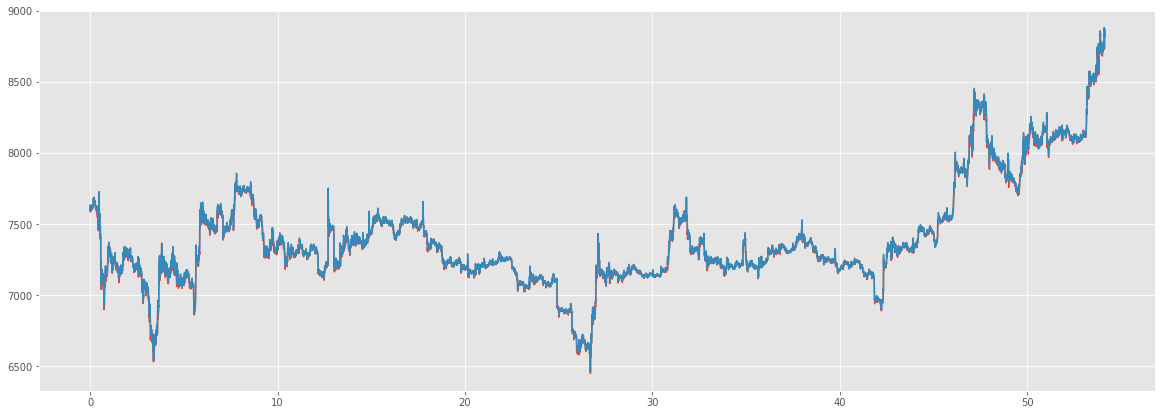

In [35]:
plt.plot(df2.index, df2[['close', 'high']])

In [36]:
df.head()

open    close     high      low   timestamp  \
datetime                                                              
2019-11-21 20:30:00  7625.38  7626.31  7632.30  7623.67  1574368200   
2019-11-21 20:35:00  7625.64  7600.47  7625.64  7594.11  1574368500   
2019-11-21 20:40:00  7600.00  7598.88  7605.62  7583.80  1574368800   
2019-11-21 20:45:00  7599.79  7590.21  7600.64  7576.03  1574369100   
2019-11-21 20:50:00  7583.23  7584.00  7591.68  7579.35  1574369400   

                        volume  period   diff timedelta  
datetime                                                 
2019-11-21 20:30:00  131.42956     300   8.63  00:00:00  
2019-11-21 20:35:00   84.75415     300  31.53  00:05:00  
2019-11-21 20:40:00  208.57723     300  21.82  00:10:00  
2019-11-21 20:45:00   92.76753     300  24.61  00:15:00  
2019-11-21 20:50:00  347.91620     300  12.33  00:20:00

In [37]:
df['rownum'] = range(len(df))
df.head()

open    close     high      low   timestamp  \
datetime                                                              
2019-11-21 20:30:00  7625.38  7626.31  7632.30  7623.67  1574368200   
2019-11-21 20:35:00  7625.64  7600.47  7625.64  7594.11  1574368500   
2019-11-21 20:40:00  7600.00  7598.88  7605.62  7583.80  1574368800   
2019-11-21 20:45:00  7599.79  7590.21  7600.64  7576.03  1574369100   
2019-11-21 20:50:00  7583.23  7584.00  7591.68  7579.35  1574369400   

                        volume  period   diff timedelta  rownum  
datetime                                                         
2019-11-21 20:30:00  131.42956     300   8.63  00:00:00       0  
2019-11-21 20:35:00   84.75415     300  31.53  00:05:00       1  
2019-11-21 20:40:00  208.57723     300  21.82  00:10:00       2  
2019-11-21 20:45:00   92.76753     300  24.61  00:15:00       3  
2019-11-21 20:50:00  347.91620     300  12.33  00:20:00       4

In [38]:
import statsmodels.formula.api as smf
df['closelog'] = np.log(df['close'])
linear_model = smf.ols('closelog ~ rownum', data=df).fit()
linear_model.summary(), linear_model.params

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:               closelog   R-squared:                       0.228
 Model:                            OLS   Adj. R-squared:                  0.228
 Method:                 Least Squares   F-statistic:                     4611.
 Date:                Fri, 17 Jan 2020   Prob (F-statistic):               0.00
 Time:                        13:57:02   Log-Likelihood:                 27270.
 No. Observations:               15595   AIC:                        -5.454e+04
 Df Residuals:                   15593   BIC:                        -5.452e+04
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------------

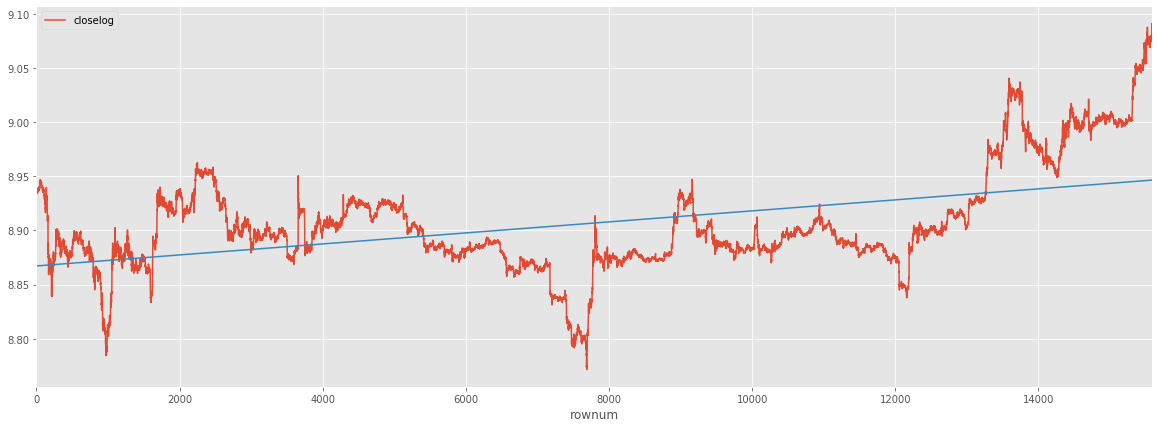

In [39]:
pred = linear_model.predict()
df.plot(kind='line', x='rownum', y='closelog')
plt.plot(df.rownum, pred, '-')

In [50]:
linear_model.resid.plot(kind='bar')

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fa37834c6a8> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fa377ea47b8> (for post_execute):


KeyboardInterrupt: 

In [41]:
mask = df.index > '2019-12-22'
df[mask]

open    close     high      low   timestamp  \
datetime                                                              
2019-12-22 00:05:00  7126.99  7128.73  7129.72  7126.99  1576973100   
2019-12-22 00:10:00  7128.65  7126.67  7130.69  7126.60  1576973400   
2019-12-22 00:15:00  7126.43  7127.69  7127.96  7124.97  1576973700   
2019-12-22 00:20:00  7127.93  7127.93  7127.93  7127.93  1576974000   
2019-12-22 00:25:00  7126.46  7128.35  7128.62  7125.53  1576974300   
...                      ...      ...      ...      ...         ...   
2020-01-14 23:40:00  8837.37  8815.43  8857.41  8800.85  1579045200   
2020-01-14 23:45:00  8815.08  8834.16  8845.88  8815.08  1579045500   
2020-01-14 23:50:00  8834.15  8852.21  8867.72  8829.62  1579045800   
2020-01-14 23:55:00  8851.87  8808.05  8851.87  8808.03  1579046100   
2020-01-15 00:00:00  8805.68  8733.57  8811.69  8707.01  1579046400   

                         volume  period    diff        timedelta  rownum  \
datetime                                                                   
2019-12-22 00:05:00     1.11191     300    2.73 30 days 03:35:00    8683   
2019-12-22 00:10:00   131.10461     300    4.09 30 days 03:40:00    8684   
2019-12-22 00:15:00     1.82158     300    2.99 30 days 03:45:00    8685   
2019-12-22 00:20:00     0.00001     300    0.00 30 days 03:50:00    8686   
2019-12-22 00:25:00     0.19438     300    3.09 30 days 03:55:00    8687   
...                         ...     ...     ...              ...     ...   
2020-01-14 23:40:00   272.93653     300   56.56 54 days 03:10:00   15590   
2020-01-14 23:45:00   484.49784     300   30.80 54 days 03:15:00   15591   
2020-01-14 23:50:00    60.31156     300   38.10 54 days 03:20:00   15592   
2020-01-14 23:55:00   211.92659     300   43.84 54 days 03:25:00   15593   
2020-01-15 00:00:00  1126.08940     300  104.68 54 days 03:30:00   15594   

                     closelog  
datetime                       
2019-12-22 00:05:00  8.871888  
2019-12-22 00:10:00  8.871599  
2019-12-22 00:15:00  8.871742  
2019-12-22 00:20:00  8.871776  
2019-12-22 00:25:00  8.871835  
...                       ...  
2020-01-14 23:40:00  9.084259  
2020-01-14 23:45:00  9.086381  
2020-01-14 23:50:00  9.088422  
2020-01-14 23:55:00  9.083421  
2020-01-15 00:00:00  9.074929  

[6912 rows x 11 columns]

In [42]:
df[mask][['close', 'high']]

close     high
datetime                             
2019-12-22 00:05:00  7128.73  7129.72
2019-12-22 00:10:00  7126.67  7130.69
2019-12-22 00:15:00  7127.69  7127.96
2019-12-22 00:20:00  7127.93  7127.93
2019-12-22 00:25:00  7128.35  7128.62
...                      ...      ...
2020-01-14 23:40:00  8815.43  8857.41
2020-01-14 23:45:00  8834.16  8845.88
2020-01-14 23:50:00  8852.21  8867.72
2020-01-14 23:55:00  8808.05  8851.87
2020-01-15 00:00:00  8733.57  8811.69

[6912 rows x 2 columns]

### Price Difference in Shifted Candlestick series

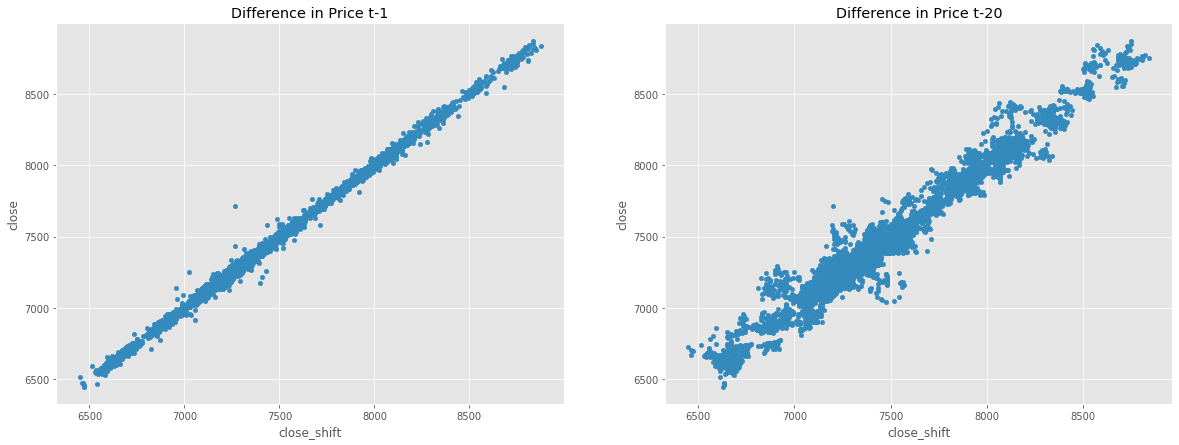

In [43]:
fig, axes = plt.subplots(ncols=2)
df['close_shift'] = df['close'].shift().fillna(method='bfill')
df.plot(kind='scatter', y='close', x='close_shift', ax=axes[0], title='Difference in Price t-1')
df['close_shift'] = df['close'].shift(20).fillna(method='bfill')
df.plot(kind='scatter', y='close', x='close_shift', ax=axes[1], title='Difference in Price t-20')

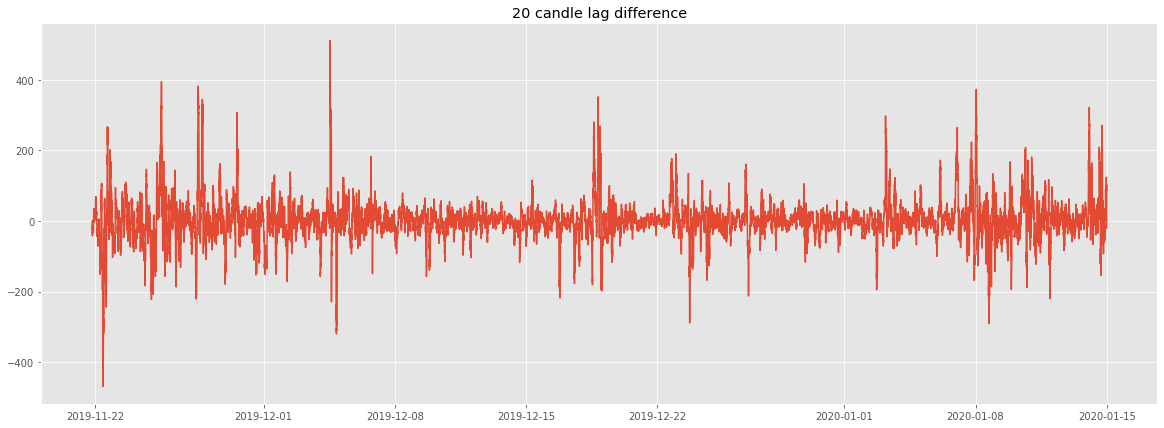

In [44]:
df['close_shift_diff'] = df['close'] - df['close_shift']
plt.title('20 candle lag difference')
plt.plot(df.index, df['close_shift_diff'])

# Rolling Average

TypeError: cannot unpack non-iterable AxesSubplot object

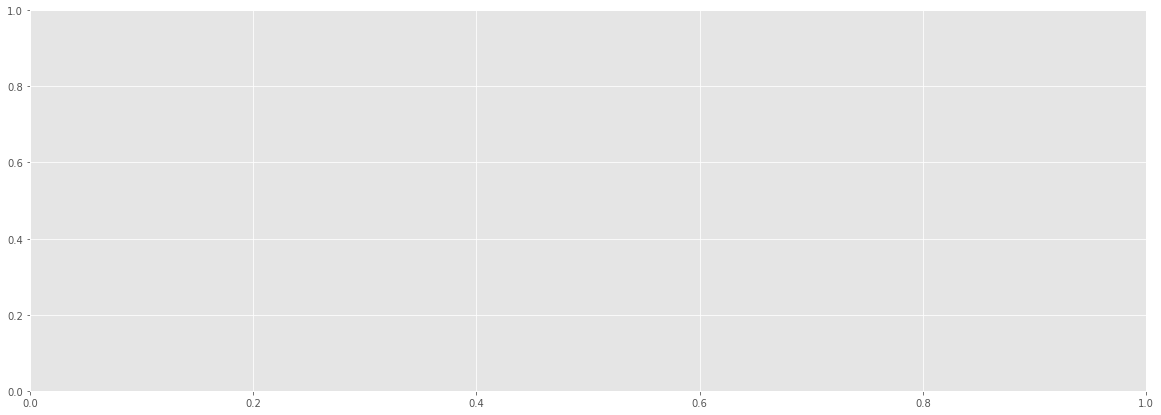

In [68]:
fig, axes = plt.subplot(1, 1, 1)
axes[0].set_facecolor('black')
plt.plot(df.index, df['close'].rolling(1000).mean().fillna(method='bfill'), label='Rolling Average', linewidth=5, color='white')
plt.fill_between(df.index, df['close'], df['close']+2*df['close'].rolling(1000).std().fillna(method='bfill'), label='standard_deviation upper', alpha=0.5)
plt.fill_between(df.index, df['close'], df['close']-2*df['close'].rolling(1000).std().fillna(method='bfill'), label='standard_deviation lower', alpha=0.5)
plt.plot(df.index, df['close'], label='price')
plt.legend()

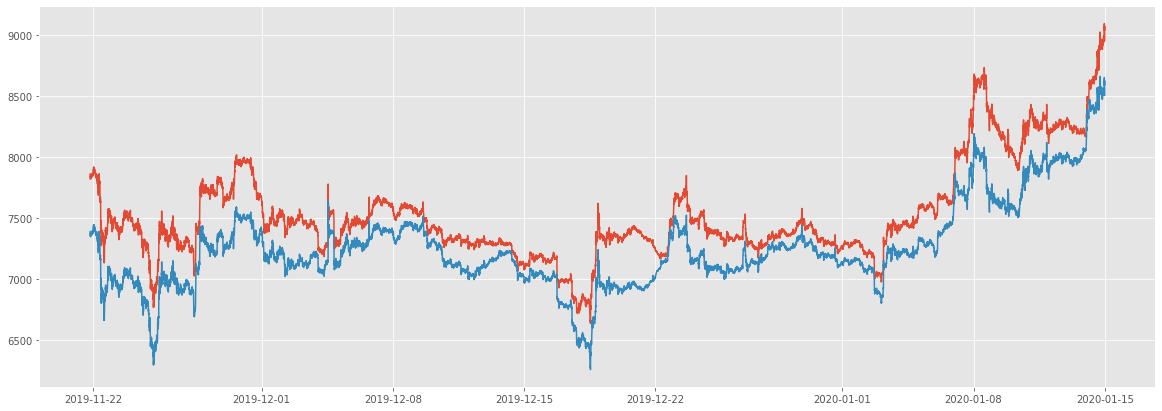

In [54]:
plt.plot(df.index, df['close']+df['close'].rolling(1000).std().fillna(method='bfill'))
plt.plot(df.index, df['close']-df['close'].rolling(1000).std().fillna(method='bfill'))

In [46]:
util.bdir(pd)

['Categorical',
 'CategoricalDtype',
 'CategoricalIndex',
 'DataFrame',
 'DateOffset',
 'DatetimeIndex',
 'DatetimeTZDtype',
 'ExcelFile',
 'ExcelWriter',
 'Float64Index',
 'Grouper',
 'HDFStore',
 'Index',
 'IndexSlice',
 'Int16Dtype',
 'Int32Dtype',
 'Int64Dtype',
 'Int64Index',
 'Int8Dtype',
 'Interval',
 'IntervalDtype',
 'IntervalIndex',
 'MultiIndex',
 'NaT',
 'NamedAgg',
 'Period',
 'PeriodDtype',
 'PeriodIndex',
 'RangeIndex',
 'Series',
 'SparseArray',
 'SparseDataFrame',
 'SparseDtype',
 'SparseSeries',
 'Timedelta',
 'TimedeltaIndex',
 'Timestamp',
 'UInt16Dtype',
 'UInt32Dtype',
 'UInt64Dtype',
 'UInt64Index',
 'UInt8Dtype',
 'api',
 'array',
 'arrays',
 'bdate_range',
 'compat',
 'concat',
 'core',
 'crosstab',
 'cut',
 'date_range',
 'datetime',
 'describe_option',
 'errors',
 'eval',
 'factorize',
 'get_dummies',
 'get_option',
 'infer_freq',
 'interval_range',
 'io',
 'isna',
 'isnull',
 'lreshape',
 'melt',
 'merge',
 'merge_asof',
 'merge_ordered',
 'notna',
 'notnull

In [47]:
df['close'].rolling(window=50).mean().fillna(method='bfill')

datetime
2019-11-21 20:30:00    7613.5482
2019-11-21 20:35:00    7613.5482
2019-11-21 20:40:00    7613.5482
2019-11-21 20:45:00    7613.5482
2019-11-21 20:50:00    7613.5482
                         ...    
2020-01-14 23:40:00    8745.0344
2020-01-14 23:45:00    8746.6250
2020-01-14 23:50:00    8748.3330
2020-01-14 23:55:00    8749.3384
2020-01-15 00:00:00    8748.9740
Name: close, Length: 15595, dtype: float64